In [1]:
import json
import pandas as pd
import geopandas as gpd
from pygeocoder import Geocoder
import numpy as np
import csv

import seaborn as sns
from seaborn import plt
from sklearn.linear_model import LinearRegression
import dateutil.parser

from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString, Polygon
import time
import random


%matplotlib inline


## school boundary info

In [2]:
with open('schoolinfo.json', 'r') as f:
     schoolinfo1=json.load(f)

schoolinfo=[]
for i in schoolinfo1:
    schoolreduce={}
    schoolreduce['gradelevel']=i['gradeLevels']
    schoolreduce['name']=i['name'].lower()
    schoolreduce['rating']=i['rating']
    schoolreduce['city']=i['address']['city'].lower()
    schoolreduce['type']=i['schoolType'].lower()
    try:
        schoolreduce['boundary']=i['boundaries']['p']['coordinates'][0][0]
    except KeyError:
        try:
            schoolreduce['boundary']=i['boundaries']['m']['coordinates'][0][0]
        except KeyError:
            continue
    schoolinfo.append(schoolreduce)

with open('schoolinfo_final.json', 'w') as f:
     json.dump(schoolinfo, f)



In [3]:
with open('schoolinfo_final.json', 'r') as f:
     schoolinfo=json.load(f)

#####schoolinfo[0]['boundaries']['m']==schoolinfo[0]['boundaries']['p']####
####True

In [14]:
polygon=[]
for i in schoolinfo:
    polygon.append(Polygon(i['boundary']))


school_geo = GeoDataFrame(schoolinfo, geometry=polygon)


In [21]:
#select only elementary schools
school_geo=school_geo[(school_geo.gradelevel!='9-12') & (school_geo.gradelevel!='7-8') &\
(school_geo.gradelevel!='7-12')& (school_geo.gradelevel!='7-9') &(school_geo.gradelevel!='6-8') &\
                     (school_geo.gradelevel!='6-12')]

In [22]:
school_geo.gradelevel.unique()

array(['K-8', 'K-5', 'K-6', 'K-3', '3-6', 'PK-5', '4-8', 'K-4', '1-3',
       '4-5', '3-5', 'PK-6', 'K-7', '2-6', '4-6', 'PK-8', '2-3', '5-8',
       '2-5', '1-5', 'K-12', 'PK-12', '5-6', '3-8', '2-8', 'PK-3', 'K-10',
       '3-4', '1-6', 'K-5, 7-9'], dtype=object)

In [25]:
len(school_geo)

4716

## house info

In [5]:
df=pd.read_csv('housedata_coords.csv')

In [7]:
#select a smaller subset
df1=df.loc[:,['street address', 'city', 'state', 'zip', 'bed', 'bath', 'sqft', 'type',
       'year-built', 'heating', 'cooling', 'parking', 'lot', 'sold-price', 'full address',
       'school1','school2', 'school3', 'dateordinal']]
len(df1)

83000

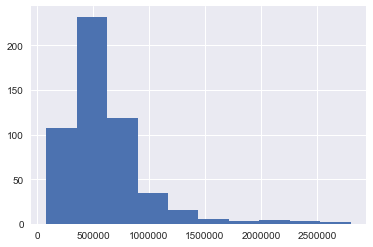

In [66]:
#remove outliers in the prices: 1st and 99th percentile
df2=df1[(df1['sold-price']<np.percentile(df1['sold-price'], 99)) & (df1['sold-price']>np.percentile(df1['sold-price'], 1))]
plt.hist(df2['sold-price'])

In [ ]:
#save the final dataset
df2.to_csv('housedata_final_final.csv', index=False)


## Final Analysis

In [4]:
df2=pd.read_csv('housedata_final_final.csv')

#after importing from csv file, the house coords becomes strings, so need to destring first
from ast import literal_eval
coords=[literal_eval(i) for i in df2['house coords']]
df2['house coords']=coords

In [5]:
#convert regular dataframe into geo_df with house coordiates as the geometry
geometry = [Point(xy[1],xy[0]) for xy in df2['house coords']]
crs = {'init': 'epsg:4326'}
house_geo = GeoDataFrame(df2, crs=crs, geometry=geometry)

In [74]:
#select the cities that are relevant
school_test=GeoDataFrame(columns=school_geo.columns)
for i in house_geo.city.unique():
    school_test=school_test.append(school_geo[school_geo.city==i.lower()])

Napa
Fairfield


In [11]:
#use the geoseries.buffer
g=school_test['geometry']
#0.2 miles in latitude is about 0.0028985
gbuffer=g.buffer(0.00289)

In [12]:
#create the school_test_buffer dataframe with only buffered coordinates
school_test_buffer=school_test.drop('geometry',1)
school_test_buffer['geometry']=gbuffer

In [14]:
#find the index of all school districts that touch each other
index=[]
for i,j in school_test.iterrows():
    index.append(i)


touch_index=[]
for i in index:
    for j in index:
        if j>i:
            if g[i].touches(g[j]):
                touch_index.append((i,j))

In [42]:
#assign treatment and control to individual houses
treat_house=GeoDataFrame(columns=house_geo.columns)
control_house=GeoDataFrame(columns=house_geo.columns)
treat_intersect=GeoDataFrame(columns=['boundary', 'city', 'gradelevel', 'name', 'rating', 'type',
       'boundary_2', 'city_2', 'gradelevel_2', 'name_2', 'rating_2', 'type_2',
       'geometry'])
control_intersect=GeoDataFrame(columns=['boundary', 'city', 'gradelevel', 'name', 'rating', 'type',
       'boundary_2', 'city_2', 'gradelevel_2', 'name_2', 'rating_2', 'type_2',
       'geometry'])
house_geo['D']=np.nan
house_geo['boundaryFE']=''
for i,j in touch_index:
    boundaryFE=school_test.name[i]+' '+school_test.name[j]+' '+school_test.city[i]
    if school_test.rating[i]<school_test.rating[j]:
        #treatment if i buffer intersect j
        treat1=gpd.GeoDataFrame(school_test_buffer.ix[[i],:])
        treat2=gpd.GeoDataFrame(school_test.ix[[j],:])
        res_intersection = gpd.overlay(treat1, treat2, how='intersection')
        treat_intersect=treat_intersect.append(res_intersection)
        for l,k in house_geo.iterrows():
            if res_intersection.geometry.contains(k['geometry'])[0]:
                treatment=school_test.rating[j]-school_test.rating[i]
                house_geo.set_value(l,'D',treatment)
                house_geo.set_value(l, 'boundaryFE', boundaryFE)
                treat_house=treat_house.append(house_geo.ix[[l],:])
        #contol if i intersect j buffer
        control1=gpd.GeoDataFrame(school_test.ix[[i],:])
        control2=gpd.GeoDataFrame(school_test_buffer.ix[[j],:])
        res_intersection1 = gpd.overlay(control2, control1, how='intersection')
        control_intersect=control_intersect.append(res_intersection1)
        for m,n in house_geo.iterrows():
            if res_intersection1.contains(n['geometry'])[0]:
                control=0
                house_geo.set_value(m,'D',control)
                house_geo.set_value(m, 'boundaryFE', boundaryFE)
                control_house=control_house.append(house_geo.ix[[m],:])
    else:
        #control if i buffer intersect j
        control1=gpd.GeoDataFrame(school_test_buffer.ix[[i],:])
        control2=gpd.GeoDataFrame(school_test.ix[[j],:])
        res_intersection1 = gpd.overlay(control1, control2, how='intersection')
        control_intersect=control_intersect.append(res_intersection1)
        for m,n in house_geo.iterrows():
            if res_intersection1.contains(n['geometry'])[0]:
                control=0
                house_geo.set_value(m,'D',control)
                house_geo.set_value(m, 'boundaryFE', boundaryFE)
                control_house=control_house.append(house_geo.ix[[m],:])
        #treatment if i intersect j buffer
        treat1=gpd.GeoDataFrame(school_test.ix[[i],:])
        treat2=gpd.GeoDataFrame(school_test_buffer.ix[[j],:])
        res_intersection = gpd.overlay(treat2, treat1, how='intersection')
        treat_intersect=treat_intersect.append(res_intersection)
        for l,k in house_geo.iterrows():
            if res_intersection.geometry.contains(k['geometry'])[0]:
                treatment=school_test.rating[i]-school_test.rating[j]
                house_geo.set_value(l,'D',treatment)
                house_geo.set_value(l, 'boundaryFE', boundaryFE)
                treat_house=treat_house.append(house_geo.ix[[l],:])



/Users/Rachel/anaconda/lib/python3.6/site-packages/geopandas/base.py:75: UserWarning: Cannot generate spatial index: Missing package `rtree`.
  warn("Cannot generate spatial index: Missing package `rtree`.")


In [43]:
#keep only the houses in the sample
house_geo_subset=house_geo.dropna()

In [61]:
#save into csv for STATA
house_geo_subset.to_csv('stata_test.csv', index=False)

In [21]:
len(house_geo),len(house_geo_subset),len(treat_intersect)

524

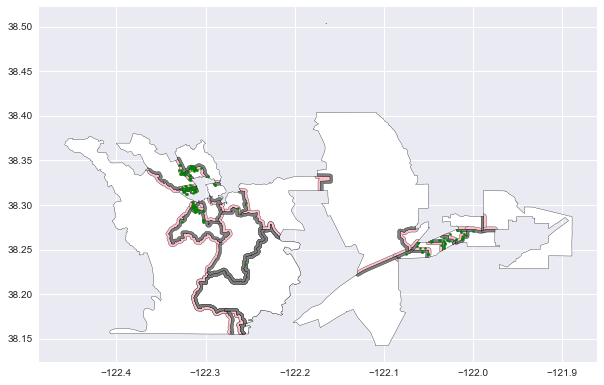

In [24]:
fig, ax = plt.subplots(figsize=(10,20))
ax.set_aspect('equal')
school_test.plot(ax=ax, color='white', edgecolor='black')
treat_intersect.geometry.plot(ax=ax, color='pink', edgecolor='black')
control_intersect.plot(ax=ax, color='grey', edgecolor='black') 
house_geo_subset.plot(ax=ax, marker='o', color='green', markersize=5)
#house_geo.plot(ax=ax, marker='o', color='red', markersize=5)


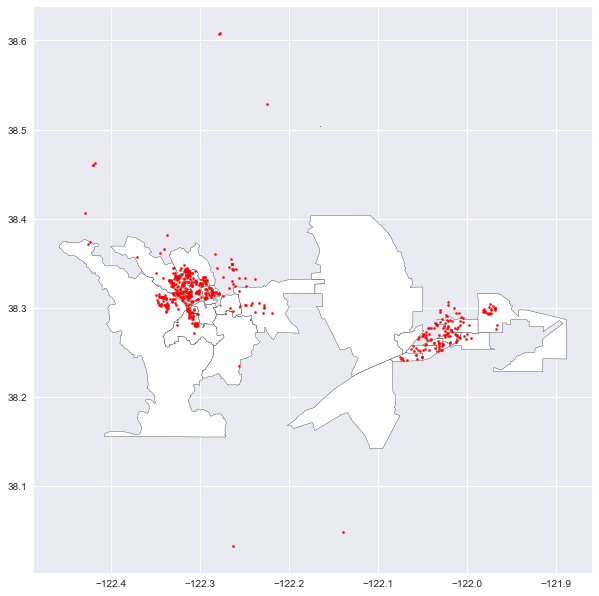

In [61]:
fig, ax = plt.subplots(figsize=(10,20))
ax.set_aspect('equal')
school_test.plot(ax=ax, color='white', edgecolor='black')
house_geo.plot(ax=ax, marker='o', color='red', markersize=5)

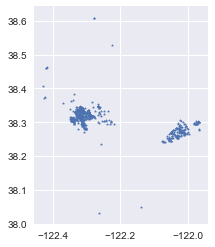

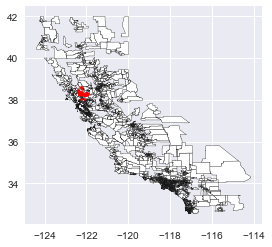

In [62]:
##plotting entire data
house_geo.plot(marker='*', markersize=5)
house_geo = house_geo.to_crs(school_geo.crs,epsg=4326)
base = school_geo.plot(color='white', edgecolor='black')
house_geo.plot(ax=base, marker='o', color='red', markersize=5)